# Backtest of multiple trades
This notebook shows possibility of backtesting multiple trades using average cost approach. 
This is not any kind of investment advice and it is just for educational purpose. 

This approach is very interesting and there is a lot of space for improvements and trying.

This kind of trading is very risky and a money management is the key. With infinity capital no care, but who have that? :]

Approaches to test to filter entries:

- ADFuller test for null hypothesis
- ML or NN for timing entries or solving other problems
- other null hypothesis aprroaches
- another combo of indicators (I dont think this is good way)
- applying deviations of lags, zscore or another 'home made' indicators
- many others..... 

In [189]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

#from Features import *

In [190]:
df=pd.read_csv('ReadyData/EURUSD_2020_2023_15M_READY.csv',index_col=0,parse_dates=True)

# Features and strategy logic

In [192]:

def rsi(df, col, n):
    df = df.copy()
    delta = df[col].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=n).mean()
    avg_loss = loss.rolling(window=n).mean()
    rs = avg_gain / avg_loss
    df[f"RSI"] = 100 - (100 / (1 + rs))
    return df

def atr(df, n):
    df = df.copy()
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df[f"ATR"] = tr.rolling(n).mean()
    return df


In [193]:
df = atr(df,5)
df['hour'] = df.index.hour
df = rsi(df,'close',21)
df.tail()


,open,high,low,close,volume,low_time,high_time,ATR,hour,RSI
time,,,,,,,,,,
2023-12-20 11:45:00,1.09629,1.09655,1.09628,1.09644,684,2023-12-20 11:45:00,2023-12-20 11:49:00,0.000562,11,45.438898
2023-12-20 12:00:00,1.09642,1.09652,1.09591,1.09600,745,2023-12-20 12:09:00,2023-12-20 12:01:00,0.000580,12,42.926829
2023-12-20 12:15:00,1.09599,1.09624,1.09495,1.09518,818,2023-12-20 12:25:00,2023-12-20 12:17:00,0.000706,12,39.344262
2023-12-20 12:30:00,1.09517,1.09552,1.09469,1.09528,724,2023-12-20 12:32:00,2023-12-20 12:42:00,0.000716,12,40.412979
2023-12-20 12:45:00,1.09528,1.09585,1.09508,1.09523,843,2023-12-20 12:58:00,2023-12-20 12:54:00,0.000754,12,40.029326


# Backtest

In [200]:
# Initializing variables to track trading positions, profit, trade counts, prices, times, drawdowns, etc.
position = None
cumulative_profit = 0
trades = []
cost = 0.0001  # Transaction cost
tp = 0.0010    # TP in price
buy_count = 0
buy_prices = []
average_buy_price = 0
buy_times = []
sell_count = 0
sell_prices = []
average_sell_price = 0
sell_times = []
drawdowns_buys = []
drawdowns_sells = []

# Loop through rows in the DataFrame 'df'
for i in range(1, len(df)):
    prev_row = df.iloc[i - 1]
    current_row = df.iloc[i]
    trading_time = current_row['hour'] > 9 and current_row['hour'] < 20

    # Generate signals for long (buy) and short (sell) positions based on RSI indicator
    long_entry = current_row['RSI'] < 30
    short_entry = current_row['RSI'] > 70

    # Execute long positions
    if long_entry and buy_count == 0:
        entry_price = current_row['close'] + cost
        entry_time = df.index[i]
        tp_price = entry_price + tp
        average_buy_price = entry_price
        position = 'long'
        buy_count = 1
        buy_prices.append(entry_price)
        buy_times.append(entry_time)
        
    # Add to an existing buy position if conditions are met
    if long_entry and buy_count > 0:
        entry_price = current_row['close'] + cost
        entry_time = df.index[i]
        buy_prices.append(entry_price)
        buy_times.append(entry_time)
        buy_count += 1
        average_buy_price = sum(buy_prices) / buy_count
        tp_price = average_buy_price + tp
        position = 'long'

    # Track drawdowns for buy positions
    if buy_count >= 0 and average_buy_price > current_row['low']:
        drawdowns_buys = (average_buy_price - current_row['low']) * buy_count


    # Closing conditions for long positions based on take-profit threshold
    if position == 'long' and (current_row['high'] > tp_price):
        exit_price = tp_price
        exit_time = df.index[i]
        drawdowns_buys = drawdowns_buys.max()
        
        # Calculate profit or loss (PnL) for each trade, update cumulative profit, and record trade details
        for j in range(buy_count):
            entry_price = buy_prices[j]
            pnl = exit_price - entry_price
            cumulative_profit += pnl
            trades.append({
                'Type': 'Long',
                'Entry Time': buy_times[j],
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Cumulative Profit': cumulative_profit,
                'Max Drawdown': drawdowns_buys 
            })

        # Reset variables for long positions after closing
        position = None
        buy_count = 0
        buy_prices = []
        buy_times = []
        drawdowns_buys = []

    # Execute short positions
    if short_entry and sell_count == 0:
        entry_price = current_row['close'] - cost
        entry_time = df.index[i]
        tp_price = entry_price - tp
        average_sell_price = entry_price
        position = 'short'
        sell_count = 1
        sell_prices.append(entry_price)
        sell_times.append(entry_time)
        
    # Add to an existing short position if conditions are met
    if short_entry and sell_count > 0:
        entry_price = current_row['close'] - cost
        entry_time = df.index[i]
        sell_prices.append(entry_price)
        sell_times.append(entry_time)
        sell_count += 1
        average_sell_price = sum(sell_prices) / sell_count
        tp_price = average_sell_price - tp
        position = 'short'

    
    # Track drawdowns for sell positions
    if sell_count >= 0 and average_sell_price < current_row['high']:
        drawdowns_sells = (current_row['high'] - average_sell_price) * sell_count

    # Closing conditions for short positions based on take-profit threshold
    if position == 'short' and (current_row['low'] < tp_price):
        exit_price = tp_price
        exit_time = df.index[i]
        drawdowns_sells = drawdowns_sells.max()
        
        # Calculate profit or loss (PnL) for each trade, update cumulative profit, and record trade details
        for j in range(sell_count):
            entry_price = sell_prices[j]
            pnl = entry_price - exit_price  # Calculate PnL for each trade
            cumulative_profit += pnl
            trades.append({
                'Type': 'Short',
                'Entry Time': sell_times[j],
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Cumulative Profit': cumulative_profit,
                'Max Drawdown': drawdowns_sells  # Include drawdown for each trade
            })
        # Reset variables for short positions after closing
        position = None
        sell_count = 0
        sell_prices = []
        sell_times = []
        drawdowns_sells = []

        
history_book = pd.DataFrame(trades)


In [201]:
history_book

,Type,Entry Time,Entry Price,Exit Time,Exit Price,PnL,Cumulative Profit,Max Drawdown
0,Long,2020-01-02 06:45:00,1.12023,2020-01-02 11:00:00,1.121370,0.001140,0.001140,0.00008
1,Long,2020-01-02 06:45:00,1.12023,2020-01-02 11:00:00,1.121370,0.001140,0.002280,0.00008
2,Long,2020-01-02 08:15:00,1.12065,2020-01-02 11:00:00,1.121370,0.000720,0.003000,0.00008
3,Long,2020-01-02 13:45:00,1.11858,2020-01-02 15:15:00,1.119580,0.001000,0.004000,0.00054
4,Long,2020-01-02 13:45:00,1.11858,2020-01-02 15:15:00,1.119580,0.001000,0.005000,0.00054
...,...,...,...,...,...,...,...,...
15599,Long,2023-12-15 19:30:00,1.09117,2023-12-20 04:45:00,1.092779,0.001609,15.600595,0.00139
15600,Long,2023-12-15 19:45:00,1.09113,2023-12-20 04:45:00,1.092779,0.001649,15.602244,0.00139
15601,Long,2023-12-15 20:15:00,1.09005,2023-12-20 04:45:00,1.092779,0.002729,15.604972,0.00139
15602,Long,2023-12-15 20:30:00,1.08944,2023-12-20 04:45:00,1.092779,0.003339,15.608311,0.00139


In [202]:
    
def calculate_performance_metrics_grid(history_book):
    # Start and End Times
    start_time = history_book['Entry Time'].min()
    end_time = history_book['Exit Time'].max()

    # Win Rate
    profitable_trades = history_book['PnL'] > 0
    win_rate = np.mean(profitable_trades) * 100  # In percentage

    # Buy and Sell Counts
    buy_count = sum(history_book['Type'] == 'Long')
    sell_count = sum(history_book['Type'] == 'Short')

    # Maximum Drawdown Calculation
    max_drawdown = history_book['Max Drawdown'].max()

    # Total Profit
    total_profit = history_book['PnL'].sum() * 10000

    # Average Time in Trade
    avg_time_in_trade = (history_book['Exit Time'] - history_book['Entry Time']).mean()
    avg_time_str = str(avg_time_in_trade).split('.')[0]  # Convert Timedelta to string and remove microseconds

    # Total Number of Trades
    total_trades = len(history_book)

    # Average wins and losses
    wins = history_book[history_book['PnL'] > 0]
    losses = history_book[history_book['PnL'] <= 0]
    win_rate = len(wins) / len(history_book)
    average_win = wins['PnL'].mean()
    average_loss = losses['PnL'].mean()

    return {
        'Start Time': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'End Time': end_time.strftime('%Y-%m-%d %H:%M:%S'),
        'Win Rate (%)': round(win_rate, 2),
        'Maximum Drawdown (pips)': round(max_drawdown, 4),
        'Total Number of Trades': total_trades,
        'Buy Count': buy_count,
        'Sell Count': sell_count,
        'Total Profit (pips)': round(total_profit, 5),
        'Average Time in Trade': avg_time_str,
        'Average win' : round(average_win,4),
        'Average loss' : round(average_loss,4)

    } 

In [203]:
calculate_performance_metrics_grid(history_book)

{'Start Time': '2020-01-02 06:45:00',
 'End Time': '2023-12-20 04:45:00',
 'Win Rate (%)': 0.75,
 'Maximum Drawdown (pips)': 0.9309,
 'Total Number of Trades': 15604,
 'Buy Count': 7669,
 'Sell Count': 7935,
 'Total Profit (pips)': 156040.0,
 'Average Time in Trade': '28 days 12:36:17',
 'Average win': 0.0054,
 'Average loss': -0.0119}

In [204]:

def plot_trades_grid(history_book, df, start_time=None, end_time=None):
    """
    Plots the entry and exit points of trades on the price chart within a specified time range,
    and also plots the cumulative PnL and drawdown over time on smaller subplots in the same row.

    :param history_book: DataFrame containing trade history with entry and exit times and prices.
    :param df: DataFrame containing the price data.
    :param start_time: The start time for the plot. If None, plotting starts from the beginning.
    :param end_time: The end time for the plot. If None, plotting goes until the end.
    """
    # Create a figure with specified subplot sizes
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1, 1]},sharex=True)

    # Filter the dataframes based on the specified time range
    if start_time is not None:
        df = df[df.index >= start_time]
        history_book = history_book[history_book['Entry Time'] >= start_time]
    if end_time is not None:
        df = df[df.index <= end_time]
        history_book = history_book[history_book['Entry Time'] <= end_time]

    # Plotting the price data
    ax1.plot(df['close'], color='blue', alpha=0.5)  # Change 'Close' to your relevant column name
    ax1.set_title('Price Chart')

    # Iterating over the trades to plot entry and exit points
    for index, trade in history_book.iterrows():
        entry_time = pd.to_datetime(trade['Entry Time'])
        exit_time = pd.to_datetime(trade['Exit Time'])
        entry_price = trade['Entry Price']
        exit_price = trade['Exit Price']

        # Plotting entry and exit points
        ax1.scatter(entry_time, entry_price, color='green' if trade['Type'] == 'Long' else 'red', marker='o')  # Green for Long, Red for Short entry
        ax1.scatter(exit_time, exit_price, color='black', marker='x')  # Black 'X' for exit

        # Connecting entry and exit with a dotted line
        ax1.plot([entry_time, exit_time], [entry_price, exit_price], color='black', linestyle=':', alpha=0.7)

    ax1.set_title('Trade Entry and Exit Points')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')

    # Plotting the cumulative PnL on the second subplot
    ax2.plot(history_book['Exit Time'], history_book['Cumulative Profit'], label='Cumulative PnL', color='purple')
    ax2.set_title('Cumulative Profit and Loss')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative PnL')

    # Calculate and Plot Inverse Drawdown on the third subplot
    drawdowns_in_pips = history_book['Max Drawdown']
    inverse_drawdowns = -drawdowns_in_pips  # Inverting the drawdown values

    # Plotting the inverse drawdown
    ax3.fill_between(history_book['Exit Time'], inverse_drawdowns, 0, where=inverse_drawdowns<=0, color='red', alpha=0.5)
    ax3.plot(history_book['Exit Time'], inverse_drawdowns, label='Inverse Drawdown', color='red')
    ax3.set_title('Inverse Drawdown')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Drawdown in Pips')

    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


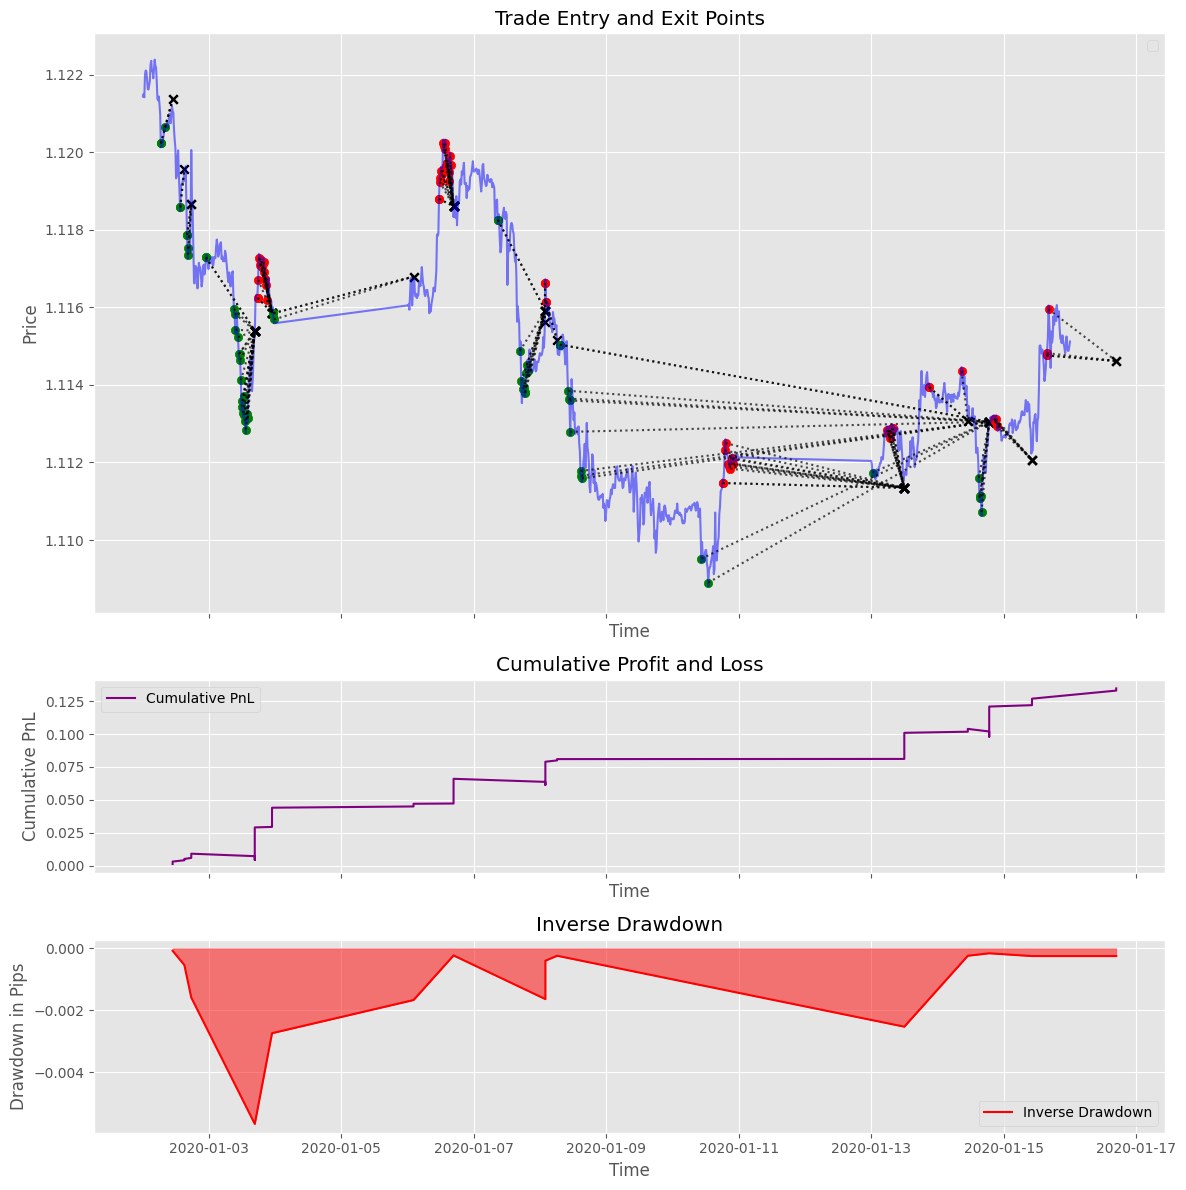

In [199]:
plot_trades_grid(history_book,df,'2020-01-02','2020-01-16')